# Setup

## Imports

In [1]:
import csv
import os.path
import librosa
import librosa.display

from IPython import display
from glob import glob
from concurrent.futures import ProcessPoolExecutor

In [2]:
from utils.wavenet_vocoder.audio import melspectrogram
from utils.wavenet_vocoder.audio import _denormalize
from utils import hparams

vai Modules

In [3]:
from vai_.utils.utils import summarize_tensor
from vai_.io import pickle_dump

Keras Modules

In [4]:
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


## Define Useful Features

In [5]:
DIR_DATA = DIR_DATA['LJSpeech']

In [6]:
get_spectrogram = lambda x: melspectrogram(x).astype(np.float32)

In [7]:
def plot_spectrogram(spectrogram):
    librosa.display.specshow(_denormalize(spectrogram), sr=hparams.sample_rate,
                             hop_length=hparams.hop_length, x_axis='time', y_axis='mel')
    plt.title('Mel spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.set_cmap('viridis')
    plt.show()

In [8]:
get_file_key = lambda filename: os.path.split(filename)[1][:-4]

## Checks

In [9]:
assert not os.path.exists(os.path.join(DIR_CHECKPOINTS, 'preprocess')), 'No need to run this again'

## Load Data

### Load Filenames and Transcripts

In [10]:
filenames = sorted(glob(os.path.join(DIR_DATA, 'wavs', '*.wav')))

In [11]:
with open(os.path.join(DIR_DATA, 'metadata.csv')) as f:
    csv_reader = csv.reader(f, delimiter='|')
    char_seq = {}
    for line in csv_reader:
        char_seq[line[0]] = line[-1]

In [12]:
no_transcripts = []
transcripts = []
for i, filename in enumerate(filenames):
    k = os.path.split(filename)[-1][:-4]
    if k in char_seq.keys():
        transcripts.append(char_seq[k])
    else:
        no_transcripts.append(i)

no_transcripts = np.array([i in no_transcripts for i in range(len(filenames))])

In [13]:
filenames = np.array(filenames)[~no_transcripts].tolist()

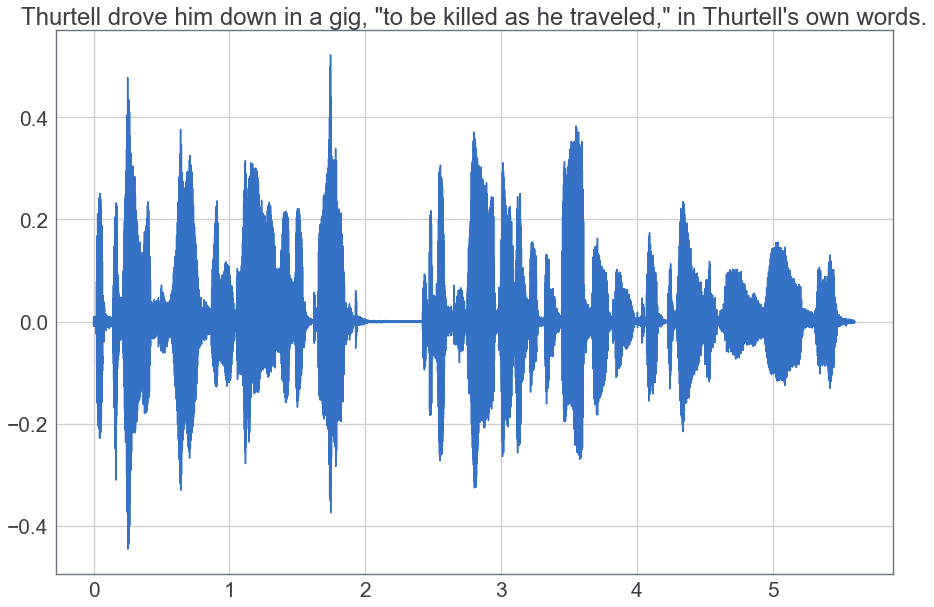

In [14]:
sample_idx = np.random.randint(len(filenames))
sample_audio = librosa.load(filenames[sample_idx], sr=hparams.sample_rate)[0]
plot(np.arange(len(sample_audio)) / hparams.sample_rate, sample_audio)
plt.title(transcripts[sample_idx])
plt.show()
display.Audio(sample_audio, rate=hparams.sample_rate)

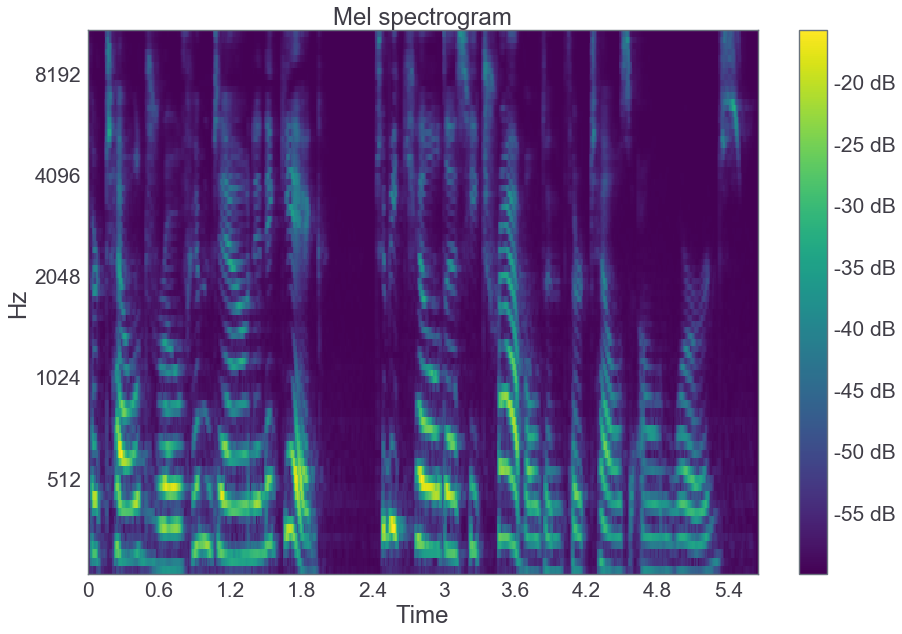

In [15]:
sample_spectrogram = get_spectrogram(sample_audio)
plot_spectrogram(sample_spectrogram)

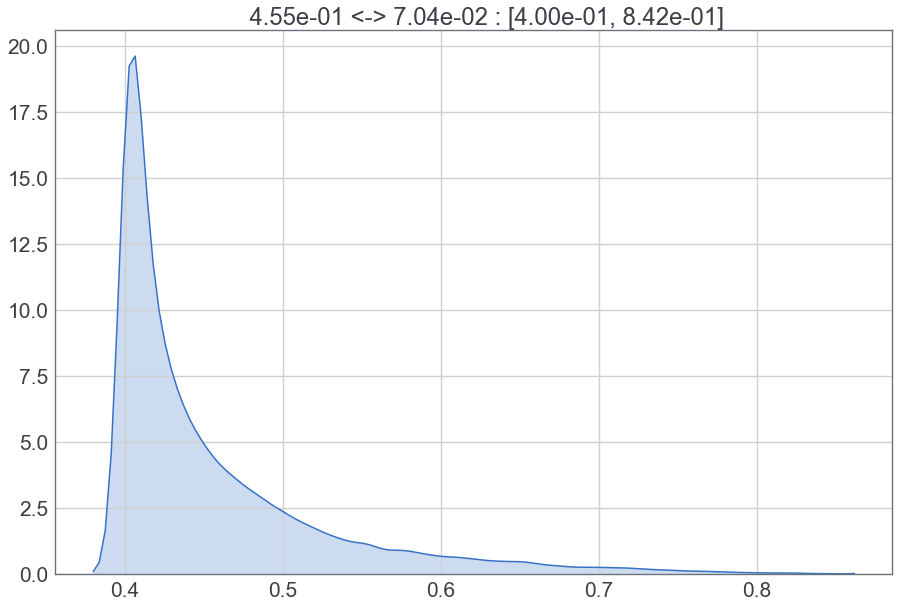

In [16]:
summarize_tensor(sample_spectrogram, kde=True)

### Tokenize

In [17]:
tokenizer = Tokenizer(filters='', char_level=True)

In [18]:
tokenizer.fit_on_texts(transcripts)

In [19]:
transcripts = [np.array(tokenizer.texts_to_sequences([t])[0]) for t in transcripts]

In [20]:
pickle_dump(os.path.join(DIR_CHECKPOINTS, 'tokenizer.p'), tokenizer)

# Preprocess and Save Data

In [21]:
%mkdir $DIR_DATA/preprocess

mkdir: cannot create directory ‘/home/vaisakh/.data/LJSpeech/preprocess’: File exists


In [73]:
def _preprocess(idx):
    filename = filenames[idx]
    y = librosa.load(filename, sr=hparams.sample_rate)[0]
    spectrogram = get_spectrogram(y)
    
    transcript = transcripts[idx]
    
    np.savez_compressed(os.path.join(DIR_DATA, 'preprocess', get_file_key(filename)),
                        transcript=transcript, spectrogram=spectrogram)
    
    return (spectrogram.mean(1), (spectrogram ** 2).mean(1), spectrogram.shape[1])

In [105]:
def preprocess(num_workers=2, chunksize=10):
    with ProcessPoolExecutor(max_workers=num_workers) as executer:
        res = executer.map(_preprocess, range(len(filenames)), chunksize=chunksize)
        
    spectrogram_stats = list(res)
    means = np.array([s[0] for s in spectrogram_stats])
    sqr_means = np.array([s[1] for s in spectrogram_stats])
    lens = np.array([s[2] for s in spectrogram_stats])
    
    mean = (means * np.expand_dims(lens, -1)).sum(0) / lens.sum()
    sqr_mean = (sqr_means * np.expand_dims(lens, -1)).sum(0) / lens.sum()
    std = np.sqrt(sqr_mean - mean ** 2)
    
    np.save(os.path.join(DIR_DATA, 'preprocess', 'stats.npy'), np.stack([mean, std]).astype(np.float32))

In [106]:
preprocess()